
## Title: Classifying the Stage of Heart Disease of Patient's from Cleveland based on Age, Resting Blood Pressure, Cholesterol, Max Heart Rate.

## Background Information

Heart disease is one of the leading causes in death across the United States of America. Heart disease can result in a broad range of negative health impacts, and can be caused by a wide variety of factors. Common heart diseases include coronary heart disease, arrhythmias, strokes, etc. Throughout the 21st century, medical professionals have deduced how certain factors may give leeway to one having a certain type of heart disease and the extent of its danger to the human body. In this project, we will try to predict the severity of heart attack given several relevant predictors.


Research Question: How can age, resting bp, chol, and chest pain be used to determine the stage of heart disease of patients from Cleveland?

In [1]:
library(tidyverse)
library(ggplot2)
library(GGally)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘GGally’ was built under R version 4.3.2”
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      

Below, we read in our dataset and manually set the column names and types according to the source of the dataset.

In [176]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                           col_types = list("d", "d", "d", "d", "d","d", "d", "d", "d", "d", "d", "f", "f", "d")) 
# cleveland_data

The rightmost column (num) will represents the labels for this model. It represents the degree of artery blockage in the patient. According to the source, 0 represents no blockage and 5 represents major blockage. We replce num with a column that buckets these values into categories "Healthy" for 0, "Early" for 1, "Medium" for values 2-3, and "Late" for 4-5. We call this column "stage". There were also some missing values that had to be removed. Finally, we split the data into our training and testing splits.

In [177]:
set.seed(69)

cleveland_data <- cleveland_data |> 
    mutate(stage = cut(num, breaks=c(-Inf,0,2,5), labels=c("Healthy","Moderate","Severe"))) |>
    filter(ca != "?") |>
    select(-num)

# Splitting into training and testing sets 
split <- initial_split(cleveland_data, prop=0.75, strata = stage)
data_training <- training(split)
data_testing <- testing(split)

head(data_training)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,stage
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,Healthy
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,Healthy
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,Healthy
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,Healthy
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,Healthy
52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,Healthy


Using the training data, we made several plots to find any potential relationships. The most notable ones are shown below.

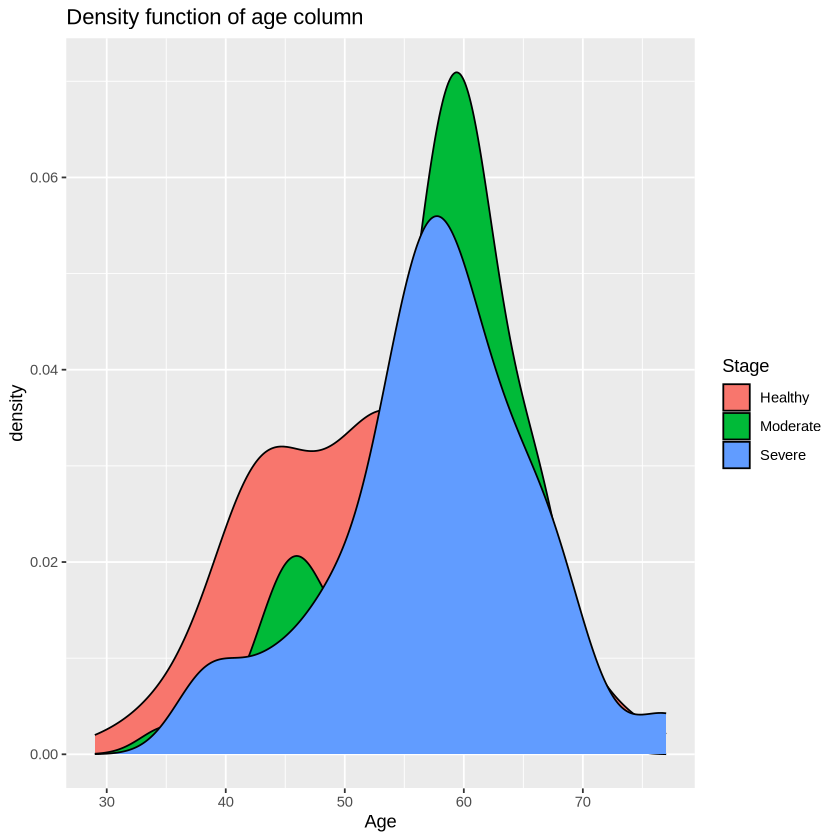

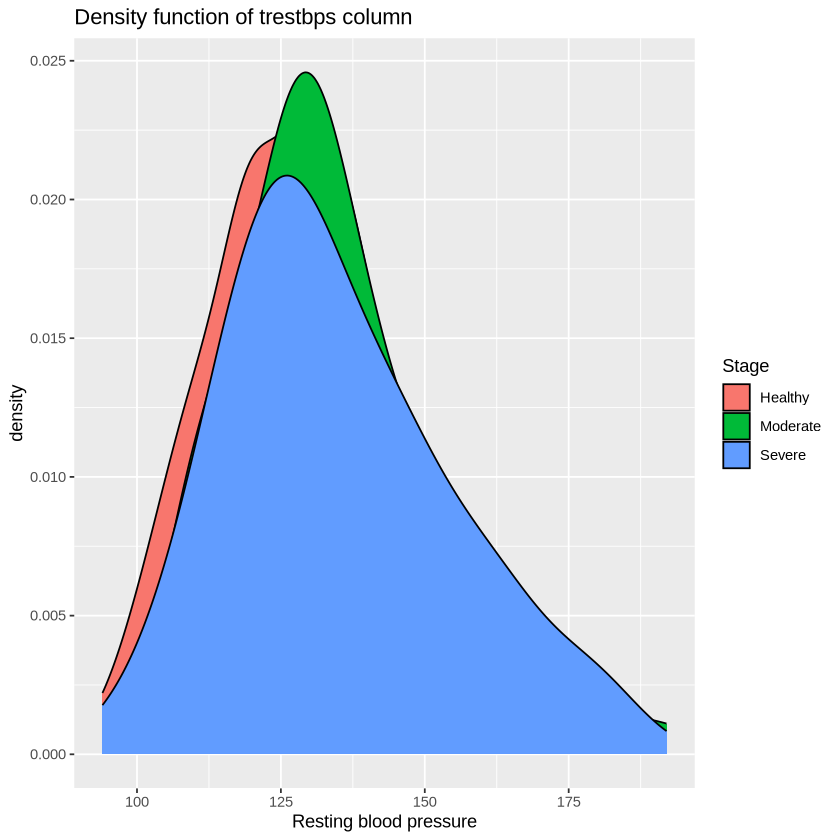

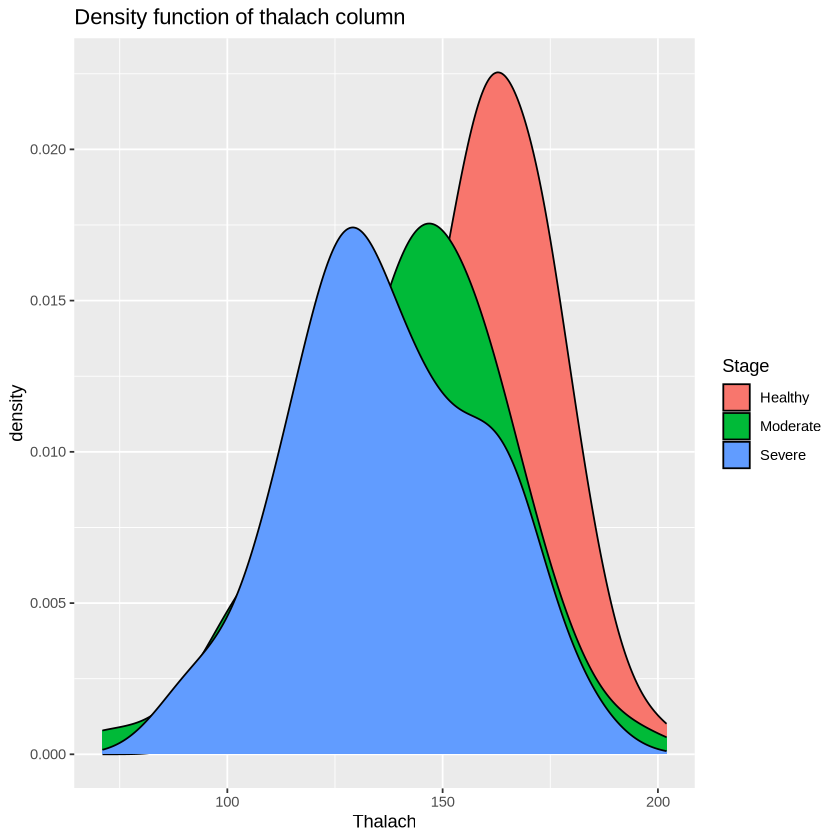

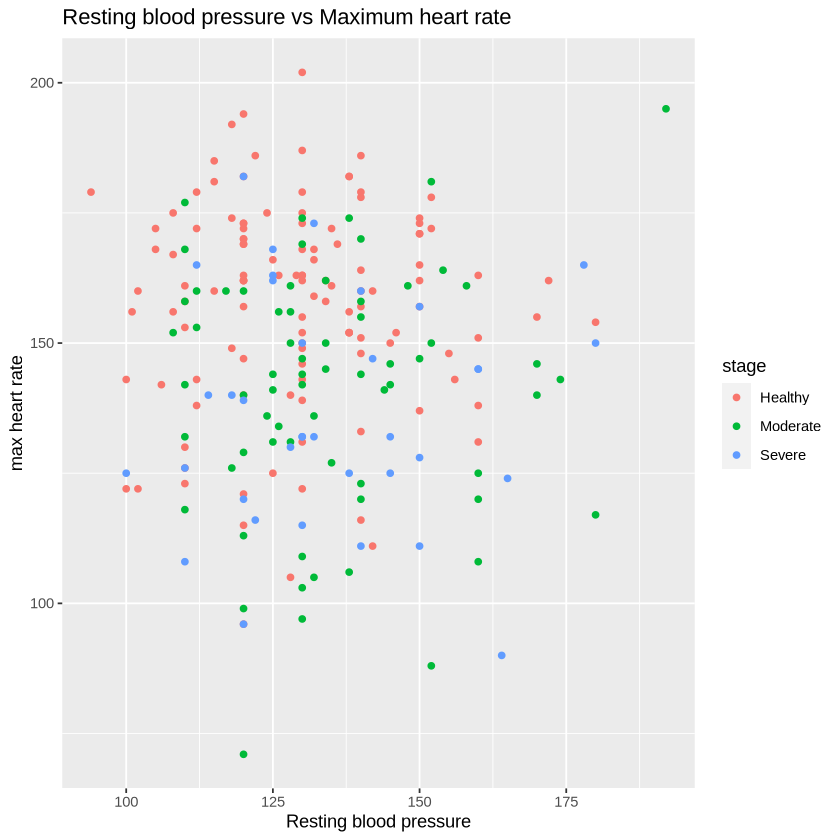

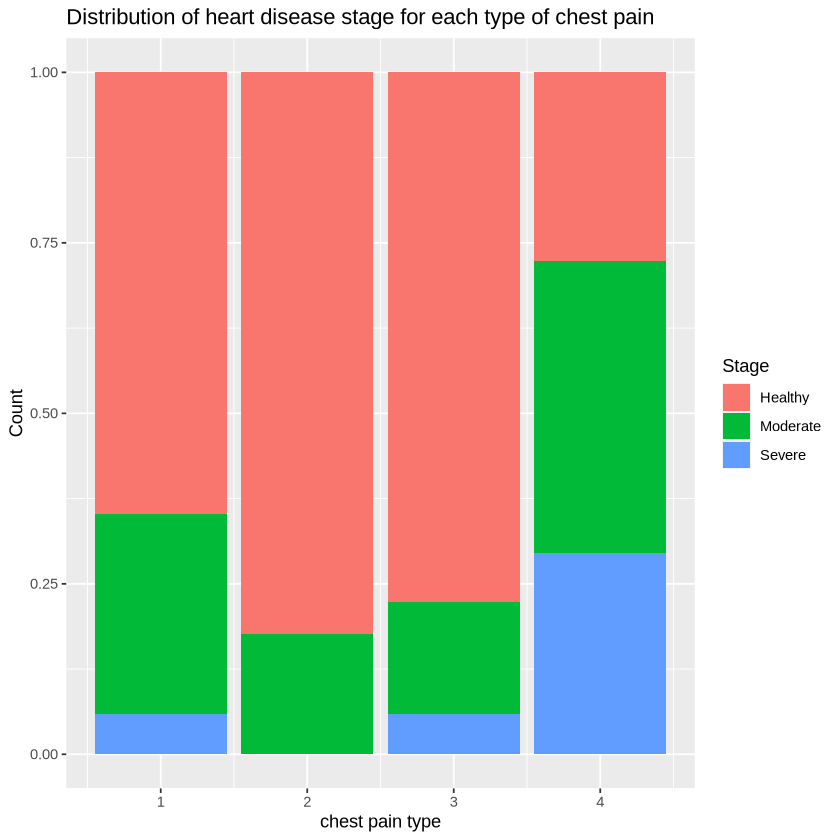

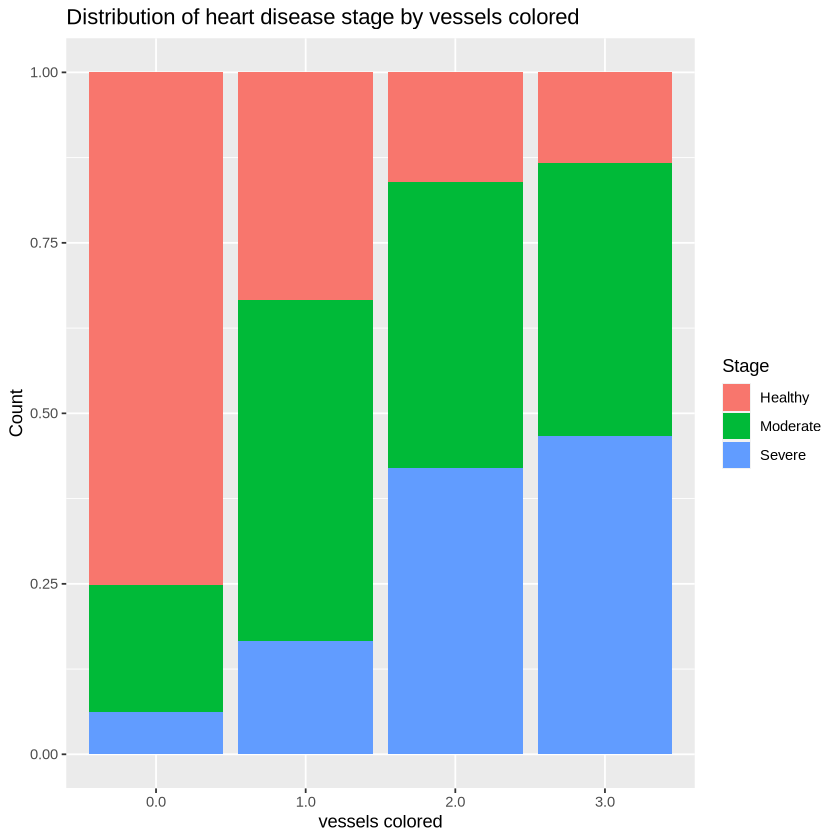

In [178]:
age <- ggplot(data_training, aes(x = age, fill = stage)) + #not much separation
    geom_density() +
    ggtitle("Density function of age column") +
    labs(x = "Age", fill="Stage")
age

tresbps <- ggplot(data_training, aes(x = trestbps, fill = stage)) + #not much separation
    geom_density() +
    ggtitle("Density function of trestbps column") +
    labs(x = "Resting blood pressure", fill = "Stage")
tresbps


thalach <- ggplot(data_training, aes(x = thalach, fill = stage)) + #not much separation
    geom_density() +
    ggtitle("Density function of thalach column") +
    labs(x = "Thalach", fill = "Stage")
thalach

bp_vs_maxhr <- ggplot(data_training, aes(x = trestbps, y = thalach)) + #good separation
    geom_point(aes(colour = stage)) +
    ggtitle("Resting blood pressure vs Maximum heart rate") +
    labs(x = "Resting blood pressure", y = "max heart rate", fill = "Stage")
bp_vs_maxhr

bar1 <- ggplot(data_training, aes(x = cp)) + #good
    geom_bar(stat = "Count", aes(fill = stage), position = "fill") +
    ggtitle("Distribution of heart disease stage for each type of chest pain") +
    labs(x = "chest pain type", y = "Count", fill = "Stage")
bar1

bar3 <- ggplot(data_training, aes(x =factor(ca, level=c('0.0','1.0','2.0','3.0')), fill = stage)) + #good
    geom_bar(stat = "count", aes(fill = stage),position="fill") +
    ggtitle("Distribution of heart disease stage by vessels colored") + 
    labs(x = "vessels colored", y = "Count", fill = "Stage")
bar3

Based on these plots, we can infer what predictors to use. However, there are other properties of the data we need to consider. Below we count the number of NA values and determine how balanced the classes are.

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,stage
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


stage,count
<fct>,<int>
Healthy,120
Moderate,67
Severe,36


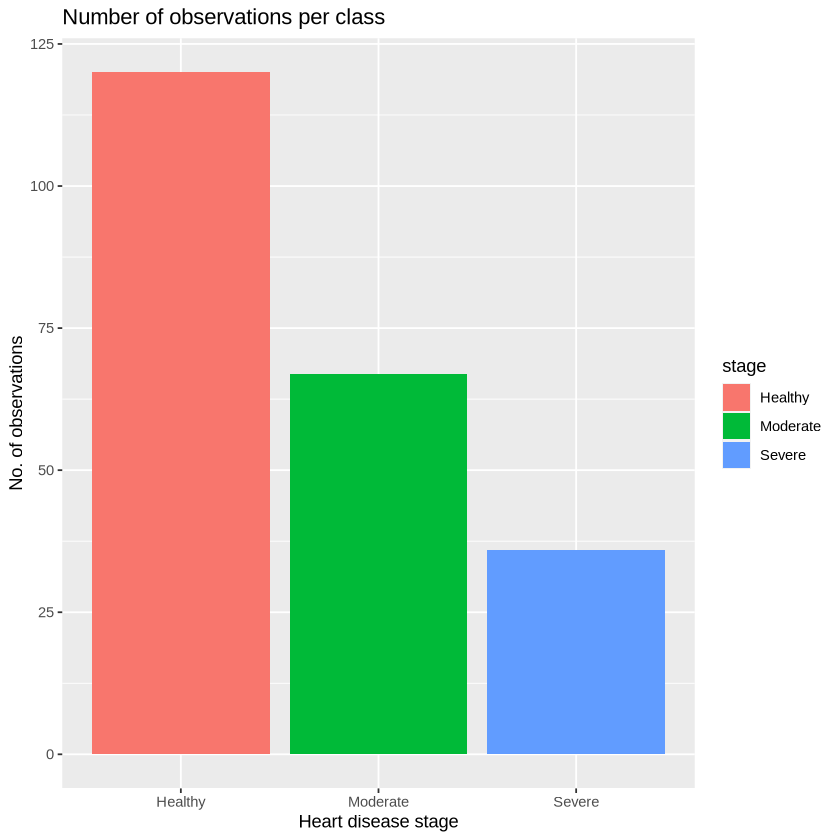

In [179]:
nulls <- data_training |> map_df(\(c) sum(is.na(c)))
nulls

balance <- data_training |> group_by(stage) |> summarize(count = n()) 
balance

balance_plot <- ggplot(balance,aes(x = stage, y = count, fill = stage)) +
    geom_bar(stat = "identity") +
    ggtitle("Number of observations per class") +
    labs(x = "Heart disease stage", y = "No. of observations")
balance_plot

Thankfully, there are no NA values in any of the columns which means our cleaning was successfully. However, there is quite a severe imbalance in classes. There are significantly more observations classified as "Healthy" than the other 3 classes. This means we will most likely need to upsample the other minority classes during training.

## Methods:
- Explain how you will conduct either your data analysis and which variables/columns you will use. *Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?*
- Describe at least one way that you will visualize the results

To decide on our predictors, we used density plots to visualize the distribution of the classes with respect to that predictor's value. We also used scatterplots to determine any overlap or relationship between potential predictors.

## Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

In [76]:
cleveland_summary <- cleveland_data |>
    mutate(ca = as.numeric(ca), thal = as.numeric(thal)) |>
    group_by(stage) |>
    summarize(across(age:thal, mean)) 
cleveland_summary

stage,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Healthy,52.58537,0.5609756,2.792683,129.2500,242.6402,0.14024390,0.8353659,158.3780,0.1402439,0.5865854,1.408537,1.560976,2.146341
Early,55.38182,0.8363636,3.345455,133.2545,249.1091,0.07272727,1.1636364,145.9273,0.4545455,1.0054545,1.636364,2.381818,2.490909
Medium,57.02817,0.8028169,3.760563,134.8169,252.9577,0.23943662,1.0985915,133.8451,0.6338028,1.8704225,1.929577,2.704225,2.633803
Late,59.69231,0.8461538,3.692308,138.7692,253.3846,0.07692308,1.6153846,140.6154,0.4615385,2.3615385,2.076923,2.384615,2.538462
